In [ ]:
# Mount google drive to access your notebook

from google.colab import drive
drive.mount('/content/drive')
  # This will prompt for authorization.

Mounted at /content/drive


In [ ]:
# Install required packages for PDF conversion -- could take over a minute
!apt update > /dev/null 2>&1
!apt install texlive-xetex pandoc > /dev/null 2>&1
!pip install nbconvert > /dev/null 2>&1

import re, pathlib, shutil
notebook_path = '/content/drive/MyDrive/Colab Notebooks' # ← CHANGE THIS TO THE FOLDER ON GOOGLE DRIVE WITH YOUR COLAB NOTEBOOK
notebook_name = 'London_bikes_Team_10_Phase_2.ipynb' # ← CHANGE THIS TO THE NAME OF YOUR COLAB NOTEBOOK
!jupyter nbconvert "{notebook_path}/{notebook_name}" --to pdf --output-dir "{notebook_path}"

# Optionally, download the exported PDF
from google.colab import files
pdf_name = notebook_path + '/' + notebook_name.replace('.ipynb', '.pdf')
files.download(pdf_name)

# Do review the pdf file to make sure everything is appearing correctly before submitting!

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/London_bikes_Team_10_Phase_2.ipynb to pdf
[NbConvertApp] Support files will be in London_bikes_Team_10_Phase_2_files/
[NbConvertApp] Making directory ./London_bikes_Team_10_Phase_2_files
[NbConvertApp] Writing 82889 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 482594 bytes to /content/drive/MyDrive/Colab Notebooks/London_bikes_Team_10_Phase_2.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Colab link
Click [here](https://colab.research.google.com/drive/1vFrv_9mGSe_KOpO9wIOEZUj0s3p1lepf#scrollTo=TAnXM5x16qth)

Team Members :  Arnav Sachdeva,  Atishay Jain,
 Nilay Jaini,  Shrinidhi Bhide



# Problem Definition

This project aims to build a supervised machine learning regression model to predict rental bicycle trip durations in London, leveraging various factors that influence rental times such as the date, day of the week, hour of the day and the particular route.



#Stakeholders

This project is primarily to aid tourists, new visitors, or anyone who is unfamiliar with the route. [Millions](https://www.statista.com/statistics/487467/overseas-visits-to-london-united-kingdom/#:~:text=Number%20of%20international%20tourist%20visits%20to%20London%2C%20UK%202011%2D2023&text=The%20number%20of%20overseas%20tourist,UK%20totaled%20nearly%2040%20million.) of tourists visit London every year, along with business people and domestic visitors. It would be helpful if they understood the trip duration required for using the bike rental system, it will optimize their stay in London and help them avoid the road traffic and the subway crowds.

The government can also use it to identify bottlenecks for infrastructure to optimise their capital expenditures.

Lastly, private sector partners like Santander Cycles can use this to optimize their revenues by bringing bikes from less used but nearby stations to more popular stations.

# Data sources, description, and cleaning/ sampling

Dataset description: Transport For London is the Government service and they have partnered with Santander cycles for this. Refer [this](https://tfl.gov.uk/modes/cycling/santander-cycles/how-it-works) for more. The dataset was taken from Google Bigquery [here](https://console.cloud.google.com/bigquery?ws=!1m5!1m4!4m3!1sbigquery-public-data!2slondon_bicycles!3scycle_hire).


We explored this dataset in SQL, we found that there was data from 2015 to 2023, but 2023 had only the data for January. So we decided to drop 2023.

For the columns, we were interested in the start_date, end_date, start_station_name, end_station_name, and the trip_duration column. Other columns were irrelevant and we dropped them.

The total number of rows were 83 million. For our project, we decided to take a smaller sample of the data. The process was as follows:

We took average duration for a given route with year, month, day of week, and start hour being the same. Then we filtered it for the top ten start station names and top ten end station names. Finally, we took 2015 and 2019 as the training datasets, and the 2022 data was kept for testing. This was done to check the impact of the year on the trip duration.


In [ ]:
# importing libraries

from google.cloud import bigquery
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression


In [ ]:
training_url = 'https://drive.google.com/uc?export=download&id=18VLSdl7LXi4sMyp4Ik8fl3j627tFD3xx'
training_trips = pd.read_csv(training_url)

training_trips.head(3)

,year,month,day_of_week,start_hour,start_station_name,end_station_name,avg_duration
0,2015,1,1,0,"Waterloo Station 3, Waterloo","Waterloo Station 3, Waterloo",0.0
1,2015,1,1,0,"Craven Street, Strand","Craven Street, Strand",1500.0
2,2015,1,1,1,"Duke Street Hill, London Bridge","Duke Street Hill, London Bridge",0.0


In [ ]:
testing_url = 'https://drive.google.com/uc?export=download&id=1TythGNbOmYdLg99RyULCqPbzcVIBv5pP'
testing_trips = pd.read_csv(testing_url)

testing_trips.head(3)

,year,month,day_of_week,start_hour,start_station_name,end_station_name,avg_duration
0,2022,1,1,0,"Craven Street, Strand","Craven Street, Strand",180.0
1,2022,1,1,0,"Craven Street, Strand","Duke Street Hill, London Bridge",900.0
2,2022,1,1,0,"Hop Exchange, The Borough","Waterloo Station 3, Waterloo",630.0


##Removing rows with zero average duration

This was done because it was disturbing our model without contributing to anything qualitative.

In [ ]:
df = training_trips.copy()

df.drop(df[(df['avg_duration'] / 60).round(1) == 0].index, inplace=True)

In [ ]:
testing_trips.drop(testing_trips[(testing_trips['avg_duration'] / 60).round(1) == 0].index, inplace=True)

##Filtering through Inter quartile range

This was done because there was still quite a lot of noise in the trip durations, and considering only the IQR for both training and testing made more sense, as the commuter can be assumed to travel at a reasonable speed- neither too fast, nor too slow.

In [ ]:
# Calculate the percentiles
Q1 = df['avg_duration'].quantile(0.25)
Q3 = df['avg_duration'].quantile(0.75)

# Filter the dataframe
df3 = df[(df['avg_duration'] >= Q1) & (df['avg_duration'] <= Q3)]

In [ ]:
Q1 = testing_trips['avg_duration'].quantile(0.25)
Q3 = testing_trips['avg_duration'].quantile(0.75)

# Filter the dataframe
test_trips = testing_trips[(testing_trips['avg_duration'] >= Q1) & (testing_trips['avg_duration'] <= Q3)]

In [ ]:
(df3['avg_duration']/60).round(1).describe()

,avg_duration
count,22201.000000
mean,12.808351
std,3.355276
min,8.000000
25%,10.000000
50%,12.700000
75%,15.800000
max,19.000000


# EDA

Peak and Off-Peak Hours: Morning and evening peaks align with office commute times, but mean ride durations differ. Early mornings (4 AM) show higher durations (20 minutes), while durations drop during the morning rush and peak again around 5 PM, coinciding with the end of the workday. An unusual rise is also observed at 11 PM.
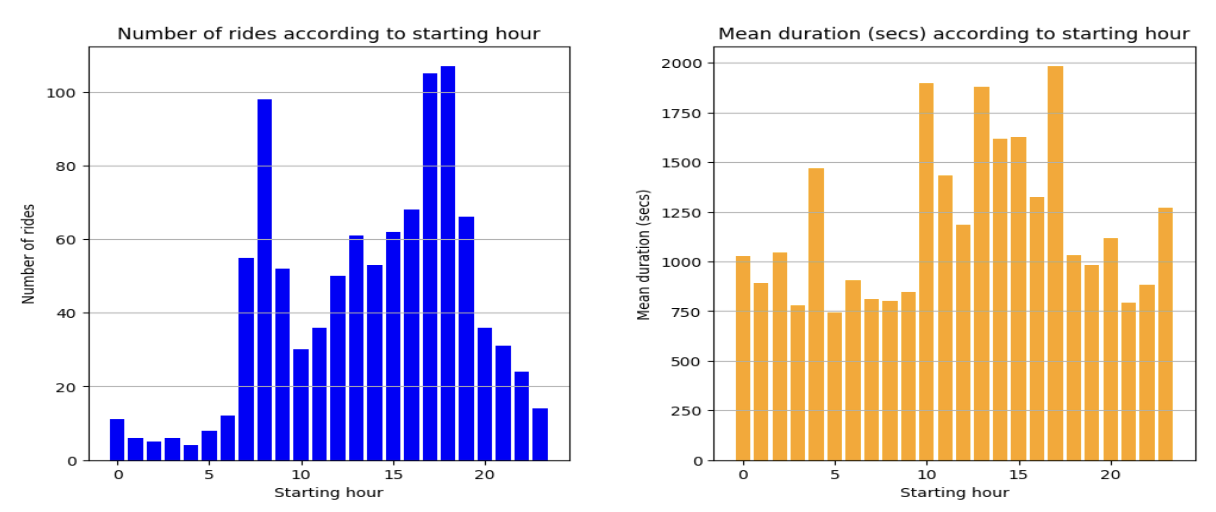

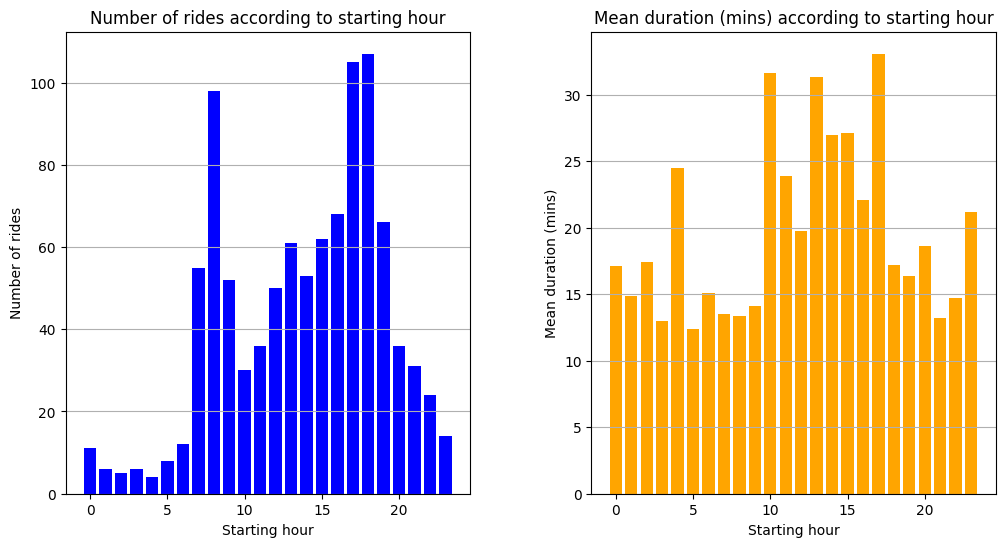

In [ ]:
cycle_trips = pd.read_csv('/content/drive/MyDrive/bq-results-20241102-222819-1730586622965/london_cycle_trips.csv')

# Busy Hours
df = cycle_trips[['start_hour','rental_id','duration']].copy()

df1 = df.pivot_table(index='start_hour', values=['rental_id','duration'], aggfunc={'rental_id': 'count', 'duration' : 'mean'}).reset_index()

df1.columns = ['start_hour', 'mean_duration', 'num_rides']

# Creating a figure and a 1x2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.subplots_adjust(wspace=0.3)  # Adjust spacing between subplots

# Plotting the first barplot in the first subplot
ax1.bar(df1['start_hour'], df1['num_rides'], color='blue')
ax1.set_title('Number of rides according to starting hour')
ax1.set_xlabel('Starting hour')
ax1.set_ylabel('Number of rides')
ax1.grid(axis='y')

# Plotting the second barplot in the second subplot
ax2.bar(df1['start_hour'], df1['mean_duration']/60, color='orange')
ax2.set_title('Mean duration (mins) according to starting hour')
ax2.set_xlabel('Starting hour')
ax2.set_ylabel('Mean duration (mins)')
ax2.grid(axis='y')

# Showing the plots
plt.show()



Weekday vs. Weekend Patterns: Weekday rides dominate, reflecting commuting trends. On weekends, ride durations are longer with Saturdays being longer than Sundays, suggesting leisure activity on Saturday specifically.
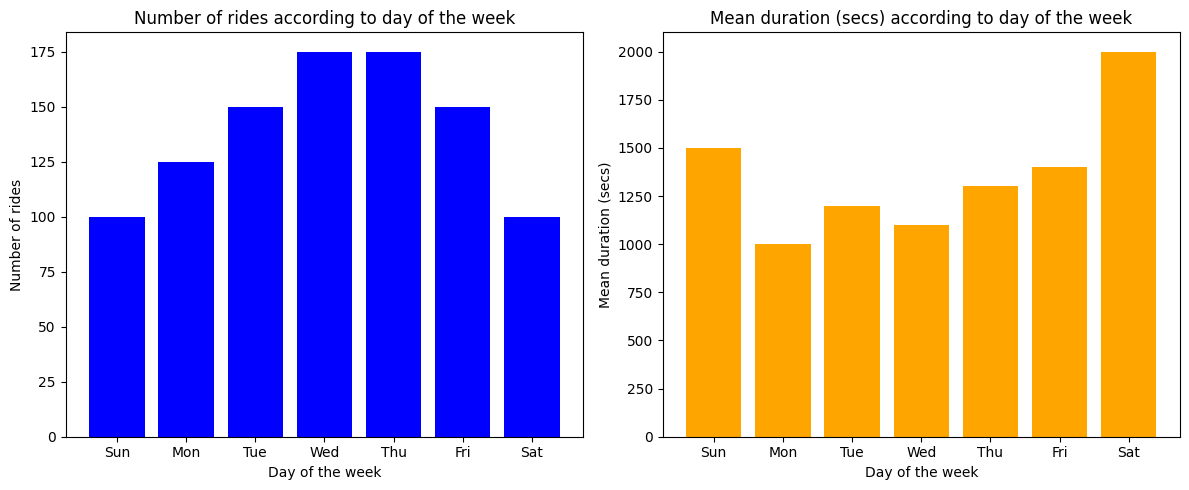

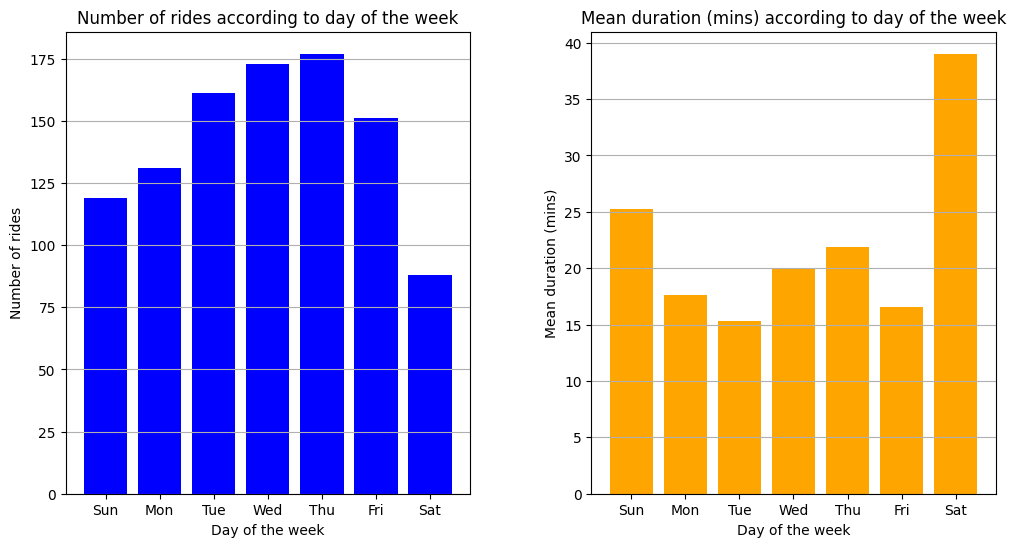

In [ ]:
# Busy Days
df = cycle_trips[['day_of_week','rental_id','duration']].copy()

df2 = df.pivot_table(index='day_of_week', values=['rental_id','duration'], aggfunc={'rental_id': 'count', 'duration' : 'mean'}).reset_index()

df2.columns = ['day_of_week', 'mean_duration', 'num_rides']

df2['day_of_week'] = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat' ]

# Creating a figure and a 1x2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.subplots_adjust(wspace=0.3)  # Adjust spacing between subplots

# Plotting the first barplot in the first subplot
ax1.bar(df2['day_of_week'], df2['num_rides'], color='blue')
ax1.set_title('Number of rides according to day of the week')
ax1.set_xlabel('Day of the week')
ax1.set_ylabel('Number of rides')
ax1.grid(axis='y')

# Plotting the second barplot in the second subplot
ax2.bar(df2['day_of_week'], df2['mean_duration']/60, color='orange')
ax2.set_title('Mean duration (mins) according to day of the week')
ax2.set_xlabel('Day of the week')
ax2.set_ylabel('Mean duration (mins)')
ax2.grid(axis='y')

# Show the plots
plt.show()

The pairplot below shows how the year affects the values in the dataset. Average duration for 2019 seems to be lower than 2015 throughtout the dataset and it is reflected in the hours, days of the week, as well as the month columns.
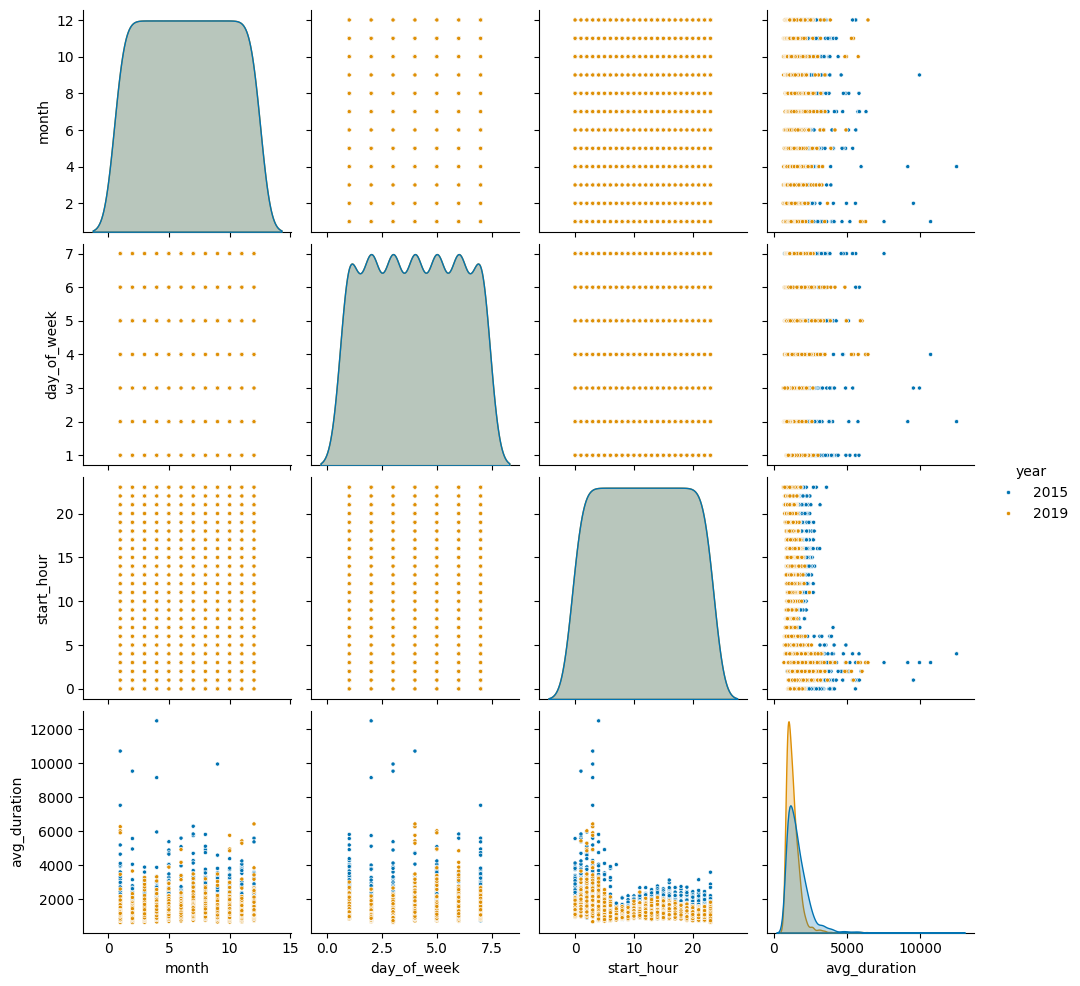

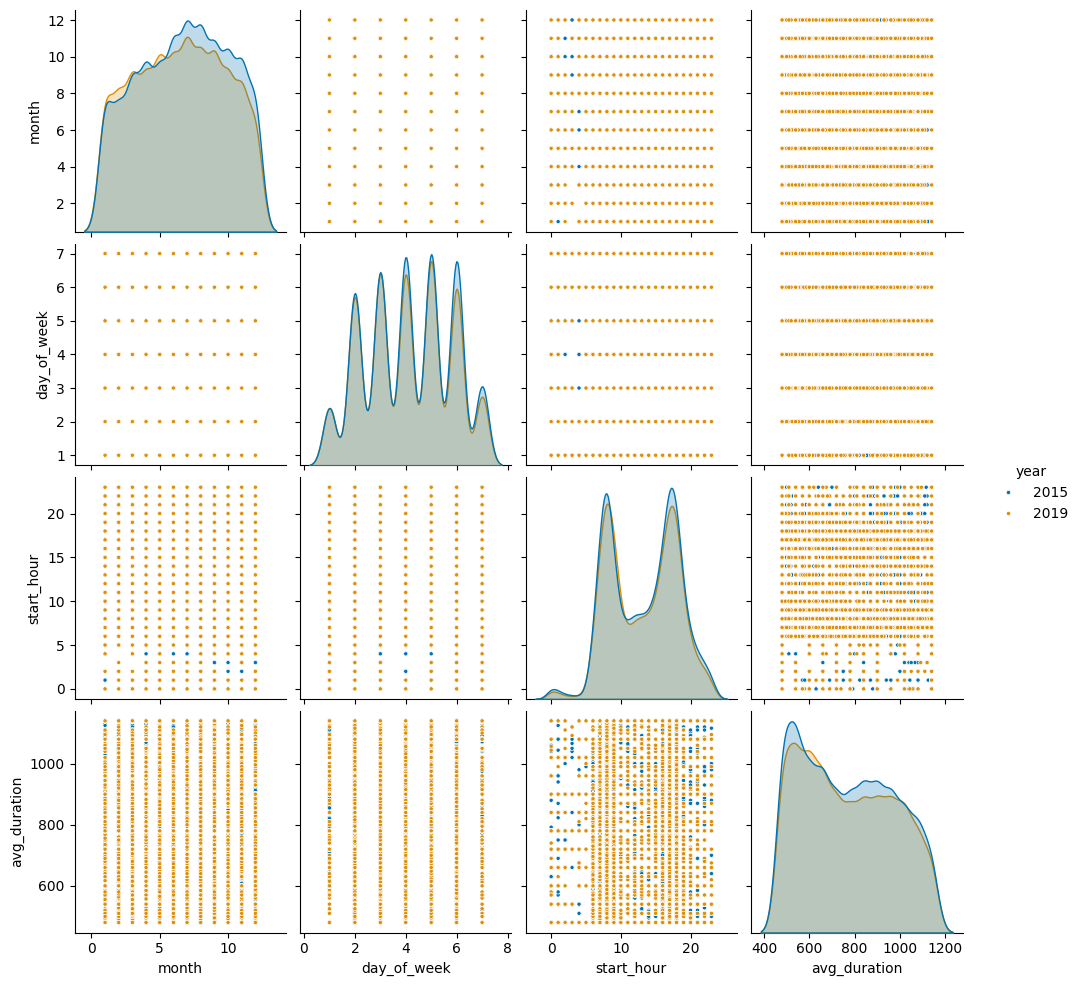

In [ ]:
attributes = ['year', 'month', 'day_of_week', 'start_hour', 'avg_duration']
sns.pairplot(df3[attributes], hue='year', markers='.', palette= 'colorblind');

#Main results pipeline

Using only ten most popular start station names and ten most popular end station names simplified our pipeline in terms of complexity. This is because these categorical variables were passed through One Hot Encoding, creating ten columns for start station names and ten columns for end station names respectively. More station names would have created more columns, resulting in a very slow learning model.

##Preprocessing

Train test split was not performed because the test data was obtained for 2022 using a separate SQL query

In [ ]:
X_train, y_train = df3.drop('avg_duration', axis = 1) , (df3['avg_duration'] / 60).round(1)

In [ ]:
X_test, y_test = test_trips.drop('avg_duration', axis = 1) , (test_trips['avg_duration'] / 60).round(1) #test data from 2022

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore") # unknown values in test → 0 for all 0/1 cols.
  )

num_pipeline = make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler())


preprocessing = ColumnTransformer([
        ("cat", cat_pipeline, ["start_station_name", "end_station_name"]),
    ],
    remainder=num_pipeline, force_int_remainder_cols=False
)

preprocessing


ColumnTransformer(force_int_remainder_cols=False,
                  remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['start_station_name', 'end_station_name'])])

##Shape after preprocessing

Twenty categorical columns were added as expected.

In [ ]:
print('Shape of original dataset: ', X_train.shape)
X_train_prepared = preprocessing.fit_transform(X_train)
X_test_prepared = preprocessing.fit_transform(X_test)
print('Shape of dataset after preprocessing: ', X_train_prepared.shape)

Shape of original dataset:  (22201, 6)
Shape of dataset after preprocessing:  (22201, 24)


##Methods which worked

Two Random Forest models with different hyperparameters and one XG Boost model obtained the same results. All of them obtained 2.47 minute RMSE on the test data which was the best amongst all the ML models we tried.

We tried Linear, Polynomial, KNN, SVR, and Ridge regressions along with their respective hyperparameter optimizations, but they could not match the results of the best models. Their RMSE was above 3 minutes.

Best Random Forest models were obtained using Random Search and Halving Search while the best XG Boost model was found using Random Search.

For scoring metric in the hyperparameter optimization, we used negative mean squared error instead of R squared, because the RMSE represented the uncertainty in the trip duration prediction, which was the parameter we were trying to reduce. That is the reason optimizing for R squared did not make sense.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

model = Pipeline([
    ('preprocessing', preprocessing),
    ('regressor', RandomForestRegressor(n_estimators=300,          # trees for accuracy
    min_samples_leaf=50,       # Larger leaf size for speed
    n_jobs=-1,                # Use all CPU cores
    max_depth = 10,
    random_state=30))
])

# Fit the pipeline
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['start_station_name',
                                                   'end_station_name'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=50,
                                       n_estimators=300, n_jobs=-1,
                                       random_state=30))])

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (mins): {(mse**0.5):.2f}")

Root Mean Squared Error (mins): 2.60


In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'regressor__n_estimators': [200],
#     'regressor__max_depth': [8, 10, 12],
#     'regressor__min_samples_leaf': [20, 50, 100]
# }

# grid_search = GridSearchCV(
#     model,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     cv=3
# )

# grid_search.fit(X_train, y_train)
# print(f"Best Parameters (Grid Search): {grid_search.best_params_}")


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define parameter distributions for random search
param_distributions = {
    'regressor__n_estimators': randint(100, 300),
    'regressor__max_depth': randint(6, 16),
    'regressor__min_samples_leaf': randint(10, 120)
}

# Initialize random search
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=15,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=3,
    random_state=42
)

# Fit the random search
random_search.fit(X_train, y_train)

# Get best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Make predictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Print results
print(f"Best Parameters: {best_params}")
print(f'Training RMSE: {rmse_train:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')

# Get detailed search results
search_results = pd.DataFrame(random_search.cv_results_)


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'regressor__max_depth': 13, 'regressor__min_samples_leaf': 12, 'regressor__n_estimators': 249}
Training RMSE: 2.0730
Test RMSE: 2.4694


In [ ]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {
    'regressor__n_estimators': [200],
    'regressor__max_depth': [8, 10, 12],
    'regressor__min_samples_leaf': [20, 50, 100]
}
halving_grid_search = HalvingGridSearchCV(
    model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=3,
    factor=2,  # Reduce candidates by a factor of 2 in each iteration
    random_state=30
)

halving_grid_search.fit(X_train, y_train)
print(f"Best Parameters (Halving Grid Search): {halving_grid_search.best_params_}")


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters (Halving Grid Search): {'regressor__max_depth': 12, 'regressor__min_samples_leaf': 20, 'regressor__n_estimators': 200}


In [ ]:
# Get the best model and its parameters
best_model = halving_grid_search.best_estimator_
best_params = halving_grid_search.best_params_

# Get the best score
best_score = halving_grid_search.best_score_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Get detailed results of the search
search_results = pd.DataFrame(halving_grid_search.cv_results_)

print(f"Best Score (mins): {(-best_score)**0.5:.2f}")



Best Score (mins): 2.25


In [ ]:
# Save the best model
import joblib
joblib.dump(random_search.best_estimator_, 'best_model_random.pkl')


['best_model_random.pkl']

In [ ]:
# To load the saved model later:
loaded_model = joblib.load('best_model_random.pkl')

# Make predictions
y_pred_train = loaded_model.predict(X_train)
y_pred_test = loaded_model.predict(X_test)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Print results

print(f'Training RMSE: {rmse_train:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')

Training RMSE: 2.0730
Test RMSE: 2.4694


In [ ]:
y_test.describe()

,avg_duration
count,10006.000000
mean,12.663612
std,3.347391
min,7.200000
25%,10.000000
50%,12.500000
75%,15.300000
max,19.000000


In [ ]:
pd.DataFrame(y_pred_test).describe()

,0
count,10006.000000
mean,12.974766
std,2.511582
min,8.704916
25%,10.935959
50%,12.792801
75%,15.326238
max,18.513562


We also tried XGBoost with Randomized Search for hyperparameter optimization. It was a lot faster than the above methods but marginally less accurate.

In [ ]:
import xgboost as xgb

# Create XGBoost regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=12,
    learning_rate=0.1,
    n_estimators=400,
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb_model.fit(X_train_prepared, y_train)

# Make predictions
y_pred_train = xgb_model.predict(X_train_prepared)
y_pred_test = xgb_model.predict(X_test_prepared)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Print results
print(f'Training RMSE: {rmse_train:.3f}')
print(f'Test RMSE: {rmse_test:.3f}')


Training RMSE: 0.466
Test RMSE: 2.852


Standard XGBoost tries to overfit on the training data. We applied Random Search to improve it.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from scipy.stats import randint


param_distributions = {
    'max_depth': randint(3, 10),
    'learning_rate': loguniform(1e-3, 1),
    'n_estimators': randint(100, 1000),
    'subsample': loguniform(0.6, 0.9),
    'colsample_bytree': loguniform(0.6, 0.9),
    'min_child_weight': randint(1, 7)
}

xgb_random = RandomizedSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror'),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=3,
    random_state=42
)

xgb_random.fit(X_train_prepared, y_train)
best_model = xgb_random.best_estimator_

In [ ]:
# Get predictions from best model
y_pred_train = xgb_random.best_estimator_.predict(X_train_prepared)
y_pred_test = xgb_random.best_estimator_.predict(X_test_prepared)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Calculate cross-validation RMSE
cv_rmse = np.sqrt(-xgb_random.best_score_)  # Convert from negative MSE

# Print comprehensive results

print(f'Training RMSE: {rmse_train:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')
print(f'Cross-validation RMSE: {cv_rmse:.4f}')



Training RMSE: 1.9980
Test RMSE: 2.4780
Cross-validation RMSE: 2.2036


It predicted RMSE of 2.4780 on the Test dataset, which is almost the same as the 2.469 of the Random Forest, but achieved in one-fifth of the time.

#Challenges

We tried various other models such as KNN, SVR, Linear and Polynomial regressions, but they could not match the RMSE of Random Forest or XG Boost. Their RMSEs were always one minute higher, i.e. roughly 3 mins, even after performing Grid, Random and Halving searches.

We also tried Ridge regression, but it was similarly unsuitable for the Test data. Test RMSE was above 3 minutes.

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=5.0)
ridge.fit(X_train_prepared, y_train)

y_pred_train = ridge.predict(X_train_prepared)
y_pred_test = ridge.predict(X_test_prepared)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Print results
print(f'Training RMSE: {rmse_train:.2f}')
print(f'Test RMSE: {rmse_test:.2f}')

Training RMSE: 2.91
Test RMSE: 3.02


Biggest challenge was the speed it took to compute the results. There was always a trade-off between speed and performance. XGBoost was the best at it while others required a lot of time to run.

#Conclusion

Random Forest with Random Search CV was marginally better than XGBoost with a Test RMSE of 2.4694 minutes as compared to XGBoost RMSE of 2.4780. That was a negligible difference, considering that it was computationally quite intensive and required six minutes more than XGBOost (which required 1 minute), without reducing the RMSE by any appreciable amount.

We found another Random Forest model optimized by Halving Search which performed similar to the above two. The runtime for it was 3 minutes, so slower than XGBoost but faster than Random Search for Random Forest. The lowest RMSE (by all three) was similar and equal to 2.47 minutes.

This means that if a commuter reaches a start station and selects an end station and provides the time, the model will predict the trip duration for the commuter which will have an RMSE of 2.47 minutes. That means, if the duration predicted is 12 minutes, they can reasonably expect to reach their destination by either 9.5 or 14.5 minutes depending on the context.

It ultimately boils down to computational speed. If we had more stations, it would be impossible to run Random Forest with Random Search, and Halving search will also take more than ten minutes. Only XGBoost can give the lowest RMSE along with speed. If time is not a problem, we can opt for the former models, but if speed is a factor, XGBoost is the best for this project.